In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor

from PIL import Image

import torchvision.transforms.functional as F
import numpy as np

import os
import matplotlib.pyplot as plt

from NNArchitectures.ImageArchitectures.AlexNet import AlexNet
from NNArchitectures.ImageArchitectures.VGG import get_VGG16, get_VGG19
from NNArchitectures.ImageArchitectures.GoogLeNet import GoogLeNet
from NNArchitectures.train import train

In [2]:
class ImageNetDataset(Dataset):
    def __init__(self, data_path, transform, how_big_part=1):
        self.data_path = data_path
        self.transform = transform
        self.items = []
        self.classes_mapping = {}
        self.how_big_part = how_big_part

        for class_index, class_ in enumerate(os.listdir(data_path)):
            self.classes_mapping[class_index] = class_
            path_to_images = os.path.join(self.data_path, class_, "images")

            images_paths = os.listdir(path_to_images)
            limit = self.how_big_part * len(images_paths)
            for i, f in enumerate(images_paths):
                full_path = os.path.join(path_to_images, f)
                self.items.append((full_path, class_index))
                if i > limit:
                    break

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, label = self.items[idx]
        image = Image.open(img_path,)
        
        if image.mode == "L":
            image = image.convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [3]:
data_path = "../tiny-imagenet-200"
#Created a folder with just a few images
train_dataset = ImageNetDataset(os.path.join(data_path,"sanity_check"), ToTensor())
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

Plotting images is always good

In [4]:
def show(imgs, labels):
    fig, axs = plt.subplots(figsize=(20,20),ncols=len(imgs), squeeze=False)
    for i, (img, label) in enumerate(zip(imgs, labels)):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        
        axs[0, i].set_xlabel(train_dataset.classes_mapping[label.item()])

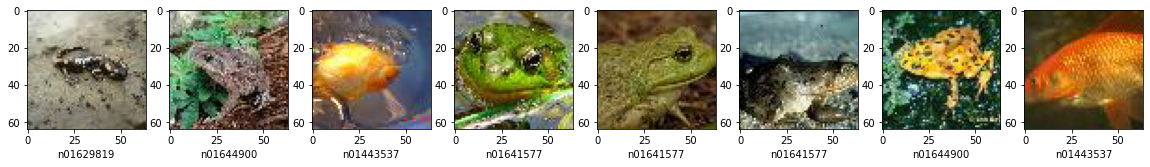

In [5]:
imgs, labels = iter(dataloader).next()
show(imgs[:8], labels[:8])

Make sure that images are normalized

In [6]:
imgs.min(), imgs.max()

(tensor(0.), tensor(1.))

Always remember to perform some sanity check whether your network is really working on some very small part of the dataset.

In [77]:
network = AlexNet(4,64,conv_norm=True, conv_drop=False, lin_norm=False, lin_drop=True).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.0001)

In [75]:
#network.load_state_dict(torch.load("models/AlexNet.pt")) This is Transfer Learning

Validation  loss: 1.3862271308898926, Validation accuracy: 0.25


Validation  loss: 1.3861751556396484, Validation accuracy: 0.25


Validation  loss: 1.3860633373260498, Validation accuracy: 0.25


Validation  loss: 1.3858410120010376, Validation accuracy: 0.25


Validation  loss: 1.3854351043701172, Validation accuracy: 0.25


Validation  loss: 1.3846752643585205, Validation accuracy: 0.25


Validation  loss: 1.383592128753662, Validation accuracy: 0.25


Validation  loss: 1.3819009065628052, Validation accuracy: 0.25


Validation  loss: 1.3796305656433105, Validation accuracy: 0.25


Validation  loss: 1.3761438131332397, Validation accuracy: 0.25


Validation  loss: 1.3710194826126099, Validation accuracy: 0.3


Validation  loss: 1.364182472229004, Validation accuracy: 0.5


Validation  loss: 1.355486273765564, Validation accuracy: 0.45


Validation  loss: 1.3456374406814575, Validation accuracy: 0.45


Validation  loss: 1.3344897031784058, Validation accuracy: 0.3


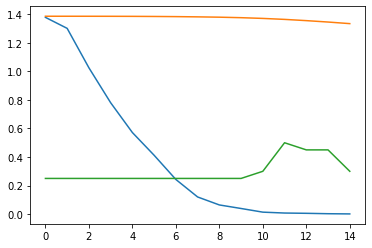

In [78]:
losses, losses_val, metrics = train(15 ,dataloader, network, loss, optimizer, device, leave_tqdm=False, valid_loader=dataloader, save_checkpoint=False)
plt.plot(np.arange(len(losses)), losses)
plt.plot(np.arange(len(losses_val)), losses_val)
plt.plot(np.arange(len(losses)), metrics)

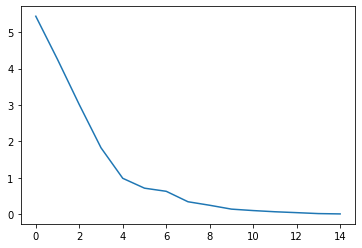

In [12]:
network = get_VGG16(num_of_classes = 200, input_size = 64, num_of_channels=3).to(device)
loss = nn.CrossEntropyLoss() #Generally if you mess up num_of_classes or prepare labeling starting from 1 you may get CUDA error
optimizer = torch.optim.Adam(network.parameters(), lr=0.0001)

losses = train(15 ,dataloader, network, loss, optimizer, device, leave_tqdm=False)
plt.plot(np.arange(len(losses)), losses)

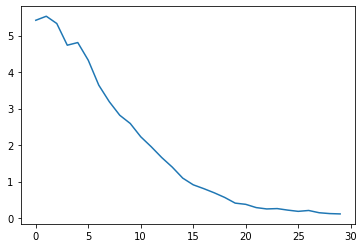

In [14]:
network = GoogLeNet(num_of_classes = 200, input_size = 64, num_of_channels=3).to(device)
loss = nn.CrossEntropyLoss() #Generally if you mess up num_of_classes or prepare labeling starting from 1 you may get CUDA error
optimizer = torch.optim.Adam(network.parameters(), lr=0.0001)

losses = train(30 ,dataloader, network, loss, optimizer, device, leave_tqdm=False)
plt.plot(np.arange(len(losses)), losses)

After some sanity checks we can try to learn the network

In [29]:
train_dataset = ImageNetDataset(os.path.join(data_path,"train"), ToTensor(), how_big_part = 0.2)
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

network = AlexNet(num_of_classes = 200, input_size = 64, conv_norm=True, conv_drop=False, lin_norm=False, lin_drop=True).to(device)
loss = nn.CrossEntropyLoss() #Generally if you mess up num_of_classes or prepare labeling starting from 1 you may get CUDA error
optimizer = torch.optim.Adam(network.parameters(), lr=0.0001)